<a href="https://colab.research.google.com/github/ZORA-IDEALE-ILHAM-S/TugasDLTM4/blob/main/TugasDLTM4/split%26eapoch100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'garbage-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F81794%2F189983%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T064932Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D939587c708cc771a9da3d29b5c17e35332abd18772f66077398c04bcb0c81255da9894365e8689753d7aa36a7d047d7d0d2ed2fa9d459f74adb78d4f461515143d3a144c61aab83272985ca9d1e4abdf90125f415269851990b936ba5e88076fd6f23c957d2bea2b0b69bb3c491c5b9ad14dcb2d614ca8595cb54dd87eeb9c583eff8eeef6ec2f5586a709515b4b4f4a106ac52b1e7a5effcc0811dce8e383baafafd7c29816862566c1f0ceb11a54e560819fe7998d09376acf7d087b8db5f141ba8fc09e68d002938074c6ce116d413bc5dd6a04856f2d3d7488cf615b117d4d6ae56e3106999278c27a6d810c5e724c1a1f8b5f5054dbe9f335e4216d6ee7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 85969666 bytes downloaded
Downloaded and uncompressed: garbage-classification
Data source import complete.


# Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up File locations and Checking sample images

In [ ]:
# setting the path and the labels list for classification of targets on the basis in human understandable form

train_dir = os.path.join('/kaggle/input/garbage-classification/Garbage classification/Garbage classification')
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# checking the size of data available to us for training out model

for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "cardboard":	 403
Images of label "glass":	 501
Images of label "metal":	 410
Images of label "paper":	 594
Images of label "plastic":	 482
Images of label "trash":	 137


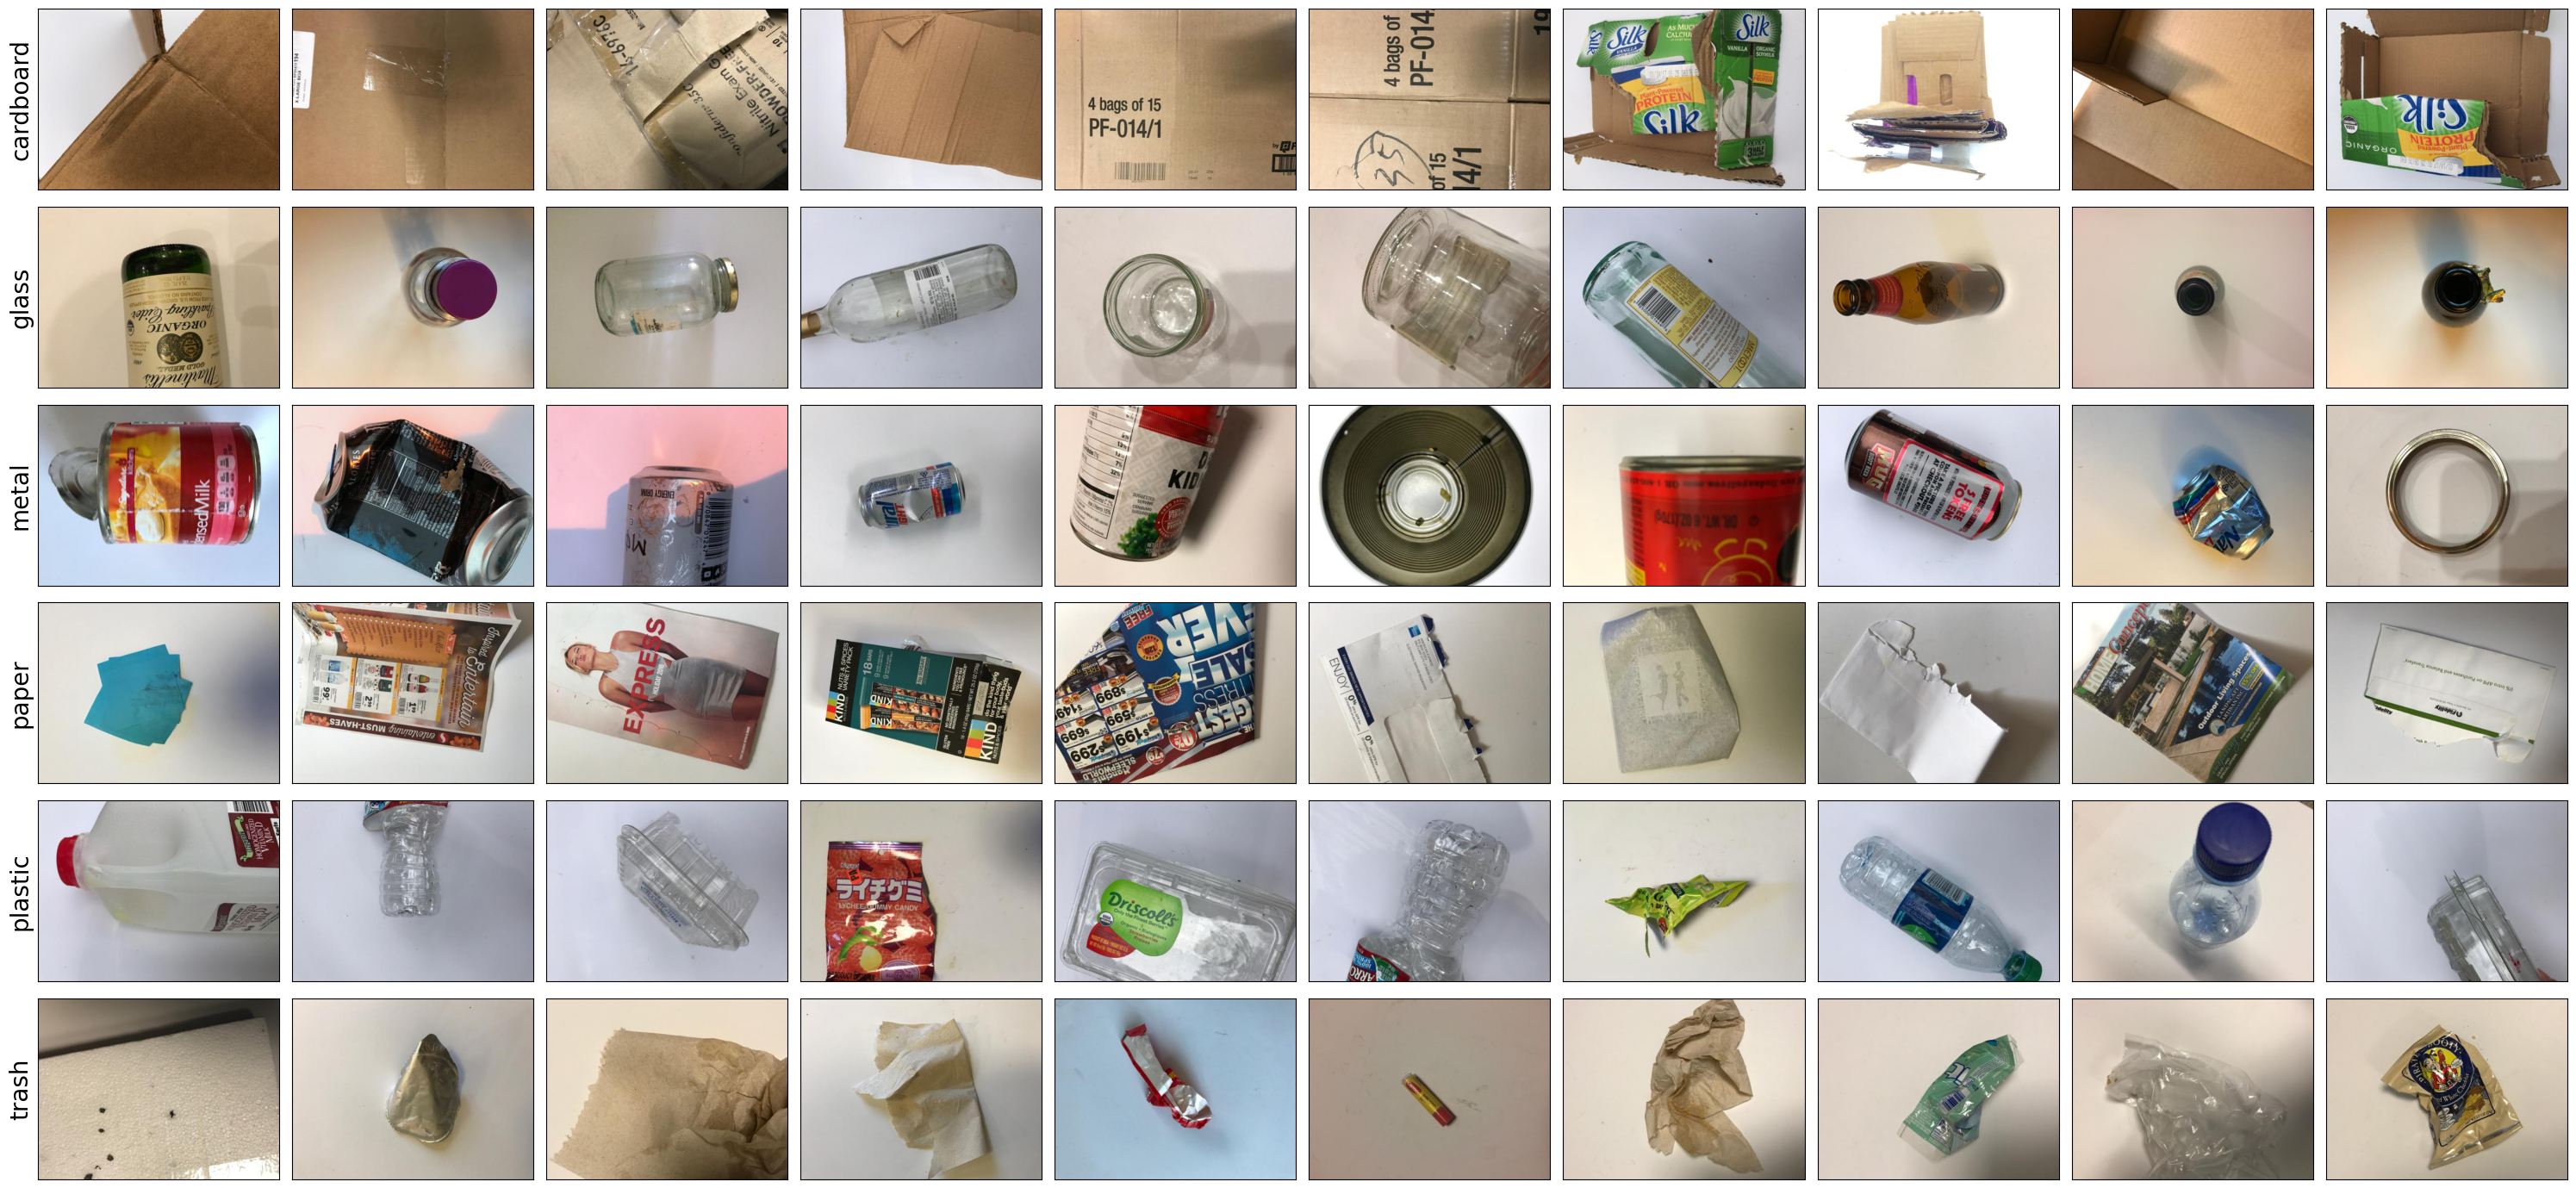

In [ ]:
# plotting images of different review for understanding the dataset

plt.figure(figsize=(30,14))

for i in range(6):
    directory = os.path.join(train_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)

        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)

        if j == 0:
            plt.ylabel(labels[i], fontsize=20)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [ ]:
# checking size of individual image

directory = os.path.join(train_dir, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

# Deep Learning

In [ ]:
# creating the model

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 512, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 382, 510, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 380, 508, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 380, 508, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 254, 32)      0         
 D)                                                              
                                                        

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                   rotation_range=15, zoom_range=0.1,
                                   width_shift_range=0.15, height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255.,
                                   validation_split=0.15)  # Mengubah validation_split menjadi 0.15

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='validation')

# Untuk data pengujian
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='validation')


Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


In [ ]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.90:
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Jika Anda menggunakan generator, Anda tidak perlu menyediakan parameter batch_size ke fit().
history = model.fit(train_generator, epochs=100, verbose=1, validation_data=validation_generator, callbacks=[callbacks])

Epoch 1/100
68/68 [==============================] - 188s 2s/step - loss: 1.6604 - accuracy: 0.4726 - val_loss: 10.4913 - val_accuracy: 0.1989
Epoch 2/100
68/68 [==============================] - 145s 2s/step - loss: 1.3259 - accuracy: 0.5409 - val_loss: 24.7088 - val_accuracy: 0.1989
Epoch 3/100
68/68 [==============================] - 144s 2s/step - loss: 1.2247 - accuracy: 0.5726 - val_loss: 37.8484 - val_accuracy: 0.1989
Epoch 4/100
68/68 [==============================] - 144s 2s/step - loss: 1.1978 - accuracy: 0.5958 - val_loss: 23.1502 - val_accuracy: 0.2095
Epoch 5/100
68/68 [==============================] - 146s 2s/step - loss: 1.1610 - accuracy: 0.5888 - val_loss: 23.6771 - val_accuracy: 0.1989
Epoch 6/100
68/68 [==============================] - 143s 2s/step - loss: 1.0918 - accuracy: 0.6284 - val_loss: 25.7933 - val_accuracy: 0.2095
Epoch 7/100
68/68 [==============================] - 145s 2s/step - loss: 1.2060 - accuracy: 0.6014 - val_loss: 7.0392 - val_accuracy: 0.1989


In [ ]:
cat = int(input('Enter any category by index: '))
ind = int(input('Enter any index to test: '))

directory = os.path.join(train_dir, labels[cat % 6])
try:
    path = os.path.join(directory, os.listdir(directory)[ind])
    img = mpimg.imread(path)
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images)
    pred = labels[np.argmax(classes)]

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual: {}      Pred: {}'.format(labels[cat], pred))

except:
    print('Invalid Value')